In [1]:
import requests
import pandas as pd

# Define the GitHub user
user = "ursa-mikail"

# GitHub API endpoint for user's repositories
repos_url = f"https://api.github.com/users/{user}/repos"

# Fetch all repositories
response = requests.get(repos_url)
repos_data = response.json()

# Initialize list to hold commit data
all_commits_data = []

# Loop through each repository
for repo in repos_data:
    repo_name = repo['name']
    print(f"Fetching commits for repository: {repo_name}")

    # GitHub API endpoint for commits in the repository
    commits_url = f"https://api.github.com/repos/{user}/{repo_name}/commits"

    page = 1
    while True:
        response = requests.get(commits_url, params={'per_page': 100, 'page': page})

        # Check if the response status code indicates an error
        if response.status_code != 200:
            print(f"Error fetching commits for repository: {repo_name}, page: {page}, status code: {response.status_code}")
            break

        response_data = response.json()

        # Check if the response contains an error message
        if isinstance(response_data, dict) and 'message' in response_data:
            print(f"Error message: {response_data['message']}")
            break

        # Break the loop if no more commits are returned
        if len(response_data) == 0:
            break

        # Process the response data
        for commit in response_data:
            try:
                commit_date = commit['commit']['author']['date'][:10]  # Get the date (YYYY-MM-DD)
                all_commits_data.append({'date': commit_date, 'repo': repo_name})
            except KeyError as e:
                print(f"KeyError: {e} in repo: {repo_name}, commit: {commit}")

        # Go to the next page
        page += 1

# Convert list to DataFrame
df = pd.DataFrame(all_commits_data)

# Group by date and count commits per day
commit_counts = df.groupby(['date', 'repo']).size().reset_index(name='commits')

# Save to CSV
file_git_commits_csv = './sample_data/git_commits.csv'
commit_counts.to_csv(file_git_commits_csv, index=False)

print("CSV file 'git_commits.csv' created successfully.")


Fetching commits for repository: challenge_and_response
Fetching commits for repository: chrome-ext-moon-phase
Fetching commits for repository: chrome-ext-utilities-timestamp-and-random-hex
Fetching commits for repository: ciphers
Fetching commits for repository: cipher_js
Fetching commits for repository: collab_interface_config_setting_ML_platform
Fetching commits for repository: convert_jupyter_notebook_to_python
Fetching commits for repository: CSV-to-HTML-table
Fetching commits for repository: curl-email
Fetching commits for repository: demo_timing_attack
Fetching commits for repository: flask-for-server_curl_simple
Fetching commits for repository: git_all_repo_static
Fetching commits for repository: golang-gaia-basic-structure
Fetching commits for repository: Golang-Introspect-Utility
Fetching commits for repository: go_sample_scaffold_working_structure
Fetching commits for repository: iframed_multiple_readmes
Fetching commits for repository: install_jupyter
Fetching commits for r

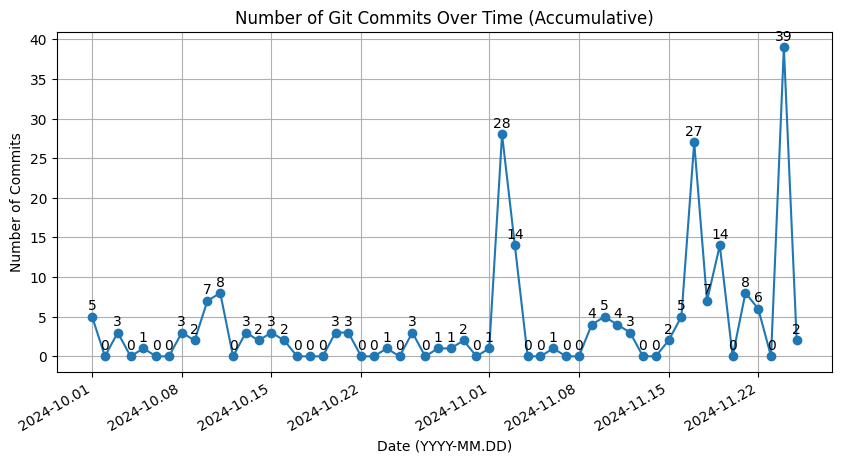

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Group by date and sum the commits
df_grouped = df.groupby('date').sum().reset_index()

# Create a date range from the start to the end date in the data
date_range = pd.date_range(start=df_grouped['date'].min(), end=df_grouped['date'].max())

# Reindex the DataFrame to include all dates in the range and fill missing dates with 0 commits
df_grouped = df_grouped.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['date'], df_grouped['commits'], marker='o', linestyle='-')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Number of Commits')
plt.title('Number of Git Commits Over Time (Accumulative)')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the number of commits
for i, row in df_grouped.iterrows():
    plt.annotate(row['commits'], (row['date'], row['commits']), textcoords="offset points", xytext=(0,5), ha='center')


plt.show()
